# Project Definition

Detect if a patient is having a seizure or not through 178 EEG readings per second.

# Dataset

https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

The dataset is available on UCI's machine learning repository here. The dataset includes 4097 electroencephalogram (EEG) readings per patient over 23.5 seconds, with 500 patients in total. The 4097 data points were then divided equally into 23 chunks per patient, each chunk is translated into one row in the dataset. Each and every row contains 178 readings, that are turned into columns; in other words, there are 178 columns that make up one second of EEG readings. All in all, there are 11,500 rows and 179 columns with the last column containing the status of the patient, whether the patient is having a seizure or not.

# Data Exploration

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [7]:
df["OUTPUT_LABEL"] = df.y == 1
df["OUTPUT_LABEL"] = df["OUTPUT_LABEL"].astype(int)
df.pop('y')
df.drop(df.columns[0], axis=1, inplace=True)

In [8]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,OUTPUT_LABEL
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


# Calculate Prevalence

The prevalence is the percentage of your samples that has the characteristic you are trying to predict. In this specific scenario, it means that the people who has a seizure is positive, while those that do not is negative. The rate is calculated by (# of positive samples / # of samples). So a .2 prevalence rate means 20% of our sample is having a seizure at that point in time.

In [9]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return sum(y_actual) / len(y_actual)


print(
    "prevalence of the positive class: %.3f"
    % calc_prevalence(df["OUTPUT_LABEL"].values)
)

prevalence of the positive class: 0.200


In [10]:
print("# of Columns:", len(df.columns))

# of Columns: 179


<b>The dataset has only one unique feature, and that's the EEG readings. The columns are split up so they are each capturing the EEG reading at a point in time, and all the points in time (all 178 columns) exist within the same second. The first column is dropped due to its uselessness in our machine learning model. The original column that contained whether or not a patient is having a seizure is also dropped, since it was a categorical variable with 5 different patient statuses. We've since converted that into a binary numerical variable called OUTPUT_LABEL</b>

# Feature Engineering

Feature engineering is the process of processing features that are categorical or ordinal into machine-readable numerical variables for our machine learning algorithm. For example, categorical string variables can be processed with one-hot encoding, or ordinal variables can be processed with label-encoding, so our machine learning algorithm can understand them.

For the epilepsy dataset, there are 178 features (columns) however, since each column represents a data point at a specific point in time and are all EEG readings, there is no need to engineer them further. Here, we make a new dataframe that only has the columns of interest and check that the columns used to define your OUTPUT_LABEL are not part of cols_input.

In [11]:
collist = df.columns.tolist()
cols_input = collist[0:178]
df_data = df[cols_input + ["OUTPUT_LABEL"]]

### Checks

In [13]:
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "you have duplicated columns in cols_input"

set()


In [14]:
# check for duplicated columns in df_data
cols_df_data = list(df_data.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0,'you have duplicated columns in df_data'

set()


In [15]:
# check the size of df_data makes sense
assert (len(cols_input) + 1) == len(
    df_data.columns
), "issue with dimensions of df_data or cols_input"

# Building Training/Validation/Test Samples
We can usually split the dataset into 50/25/25, 60/20/20, 70/15/15 as the split for training/validation/test samples; this also depends on how many samples we have. If we have an extremely huge dataset (hundreds of millions of rows) then we can even use a split such as 98/1/1. The training split is used to train our machine learning algorithm, hence why we would want to use the majority of our dataset. The validation dataset is use to tune hyperparameters and to select the best performing approach. The testing dataset is used to test the accuracy of our machine learning model.

In [16]:
df_data = df_data.sample(n=len(df_data))
df_data = df_data.reset_index(drop=True)

In [17]:
df_valid_test = df_data.sample(frac=0.3)
print("Validation/Test Split Size: %.1f" % (len(df_valid_test) / len(df_data)))

df_test = df_valid_test.sample(frac=0.5)
df_valid = df_valid_test.drop(df_test.index)

df_train_all = df_data.drop(df_valid_test.index)

Validation/Test Split Size: 0.3


In [18]:
# check the prevalence of each
print(
    "Test prevalence(n = %d):%.3f"
    % (len(df_test), calc_prevalence(df_test.OUTPUT_LABEL.values))
)
print(
    "Valid prevalence(n = %d):%.3f"
    % (len(df_valid), calc_prevalence(df_valid.OUTPUT_LABEL.values))
)
print(
    "Train all prevalence(n = %d):%.3f"
    % (len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values))
)

Test prevalence(n = 1725):0.211
Valid prevalence(n = 1725):0.225
Train all prevalence(n = 8050):0.192


In [19]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 11500)


<b>We want to balance our dataset to avoid creating a model where it incorrectly classifies samples as belonging to the majority class. We balance our dataset so that the proportions of each class is the same to avoid creating a dumb model. Since we have 2300 positive samples, we can use the sub-sample balancing method to only use a random subset of the negative samples.</b>

In [20]:
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

n = np.min([len(df_train_pos), len(df_train_neg)])

df_train = pd.concat([df_train_pos.sample(n=n, random_state=69), df_train_neg.sample(n=n, random_state=69)], axis=0, ignore_index=True)

df_train = df_train.sample(n=len(df_train), random_state=69).reset_index(drop=True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 3096):0.500


In [21]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [22]:
import pickle
pickle.dump(cols_input, open('cols_input.sav', 'wb'))


In [23]:
# a function to fill missing values with mean of the column if needed
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [24]:
# create the X and y matrices
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
scaler.fit(X_train_all)

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

Training All shapes: (8050, 178)
Training shapes: (3096, 178) (3096,)
Validation shapes: (1725, 178) (1725,)


# Model Selection

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [26]:
import warnings
warnings.filterwarnings('ignore')

<b>Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.</b>

In [27]:
thresh = 0.5

# Model Selection: baseline models

## K nearest neighbors (KNN)

KNN stands for K Nearest Neighbor, and it's a classification model that classifies the sample based on the class of k samples that are closest to it. For example, if k=3, and all three of the samples nearest the sample in question is class 1, then the sample in question would be classified as class 1. If two out of the three nearest the sample in question is class 1, then the sample in question would have a probability of 66% to be classified as class 1.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.993
accuracy:0.619
recall:0.240
precision:0.995
specificity:0.999
prevalence:0.500
 
Validation:
AUC:0.965
accuracy:0.825
recall:0.222
precision:1.000
specificity:1.000
prevalence:0.225
 


## Logistic Regression

Logistic regression is a type of generalized linear model, which are a generalization of the concepts and abilities of regular linear models.

Logistic regression takes your input features, then performs a linear function on it by projecting the sample points onto the line. The linear function is performed by summing the log of likelihood of each sample point and produces a best fitting logistic regression line by maximizing the log of likelihood, which is the same thing as maximizing the likelihood. The best fitting function would predict the probability of the positive class as very close to 1 (100%), and the negative class to be very close to 0, in a binary classification model.

However, maximizing the cost function will lead to overfitting the function itself, so we penalized the function by performing L1, L2, or elastic net regularization. Lastly, gradient descent is performed to minimize the cost function with regularization.

Note that logistic regression produces the probability of a class, so in order to turn this into a binary classification model we need to set a threshold for the probability of the positive class. For example, if p(male) > 0.5 then classify it as male.

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 69)
lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.625
accuracy:0.658
recall:0.541
precision:0.706
specificity:0.775
prevalence:0.500
 
Validation:
AUC:0.510
accuracy:0.677
recall:0.436
precision:0.333
specificity:0.746
prevalence:0.225
 


## Stochastic Gradient Descent

Gradient descent is an algorithm that minimizes many loss functions across many different classes of models, such as linear regression, logistic regression, and clustering models. In a linear regression model, GD starts by plotting all possible sum of squared residuals and calculates the slope by taking its derivative at its chosen point. GD then fines the lowest slope of the curve, and in linear regression its when the derivative is 0. In other models, GD finds the minimum slope by taking initial guesses at big steps and smaller steps when it is closer to reaching the minimum value; this makes gradient descent very useful when it is not possible to solve for where the derivative equals 0.

The steps is determined by a hyperparameter called the learning rate, or alpha in scikitlearn. In linear regression, it takes the slope at the current point and multiply it by the learning rate, so as the derivative gets smaller, the steps will get smaller as well. GD stops taking steps when the step size is very close to 0, in practice it stops when the step size is smaller than 0.001. GD can also include a limit on the number of steps it will take before giving up, in practice the maximum number of steps is 1,000 or greater.

When we perform gradient descent on models with two or more parameters, the loss function is not a 2D graph anymore. In general, gradient descent takes the derivative of the loss function for each parameter in it, and GD descends to the lowest derivative point of the loss function. Stochastic here means how much of the data you are using. Stochastic gradient descent is significantly faster than GD since SGD uses only parts of the data and GD uses all of the data to perform gradient descent.

In our binary classification algorithm, the loss function is log odds, so SGD will minimize the same loss function as logistic regression.

In [30]:
from sklearn.linear_model import SGDClassifier
SGDC = SGDClassifier(loss = 'log',alpha = 0.1)
SGDC.fit(X_train_tf, y_train)

y_train_preds = SGDC.predict_proba(X_train_tf)[:,1]
y_valid_preds = SGDC.predict_proba(X_valid_tf)[:,1]

print('SGDC')
print('Training:')
SGDC_train_auc, SGDC_train_accuracy, SGDC_train_recall, \
    SGDC_train_precision, SGDC_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
SGDC_valid_auc, SGDC_valid_accuracy, SGDC_valid_recall, \
    SGDC_valid_precision, SGDC_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

SGDC
Training:
AUC:0.560
accuracy:0.574
recall:0.522
precision:0.583
specificity:0.627
prevalence:0.500
 
Validation:
AUC:0.517
accuracy:0.575
recall:0.495
precision:0.263
specificity:0.598
prevalence:0.225
 


## Naive Bayes

The naive Bayes classifier uses the Bayes theorem to perform classification. It assumes that if all features are not related to each other, then the probability of seeing the features together are just the product of the probability of each feature happening.

It finds the probability of each feature given each class. For example, if one of our feature is weather outlook and out dependent variable is whether or not we will play golf, we will find the probability of each weather outlook category given that we play and dont play.

Using these results, we multiply all of them together. This gives us a value that represents the probability of X given a class times a probability of a class. P(X|C)P(C). We do this for both classes, then divide both sides by P(X) to normalize.

Lastly, to determine whether or not we will classify a sample under scenario X, we compare the normalized probability of scenario X given its class, the sample will then be classified under the class that has a larger probability.

In [31]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, \
nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, \
nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.986
accuracy:0.942
recall:0.907
precision:0.974
specificity:0.976
prevalence:0.500
 
Validation:
AUC:0.984
accuracy:0.954
recall:0.881
precision:0.910
specificity:0.975
prevalence:0.225
 


## Decision Tree Classifier

In general, a decision tree asks a question, then classifies the sample based on the answer. The classification can be categories, or numeric. The classifying algorithm works by repetitively separating data into sub regions of the same class and the tree ends when the algorithm has divided all samples into classes that are pure, or by meeting some critieria of the classifier attributes.

The top of the tree is called a Root Node or The Root. Nodes that stem further, are called Internal Nodes or just Nodes, they have arrows pointing to them AND away from them. Lastly, Leaf Nodes or just Leaves, have arrows pointing to them but not away from them.

Features with better split, will be placed in the nodes by order of lower Gini impurity scores.

In [32]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 10, random_state = 69)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=69, splitter='best')

In [33]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, \
tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, \
tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.985
accuracy:0.978
recall:0.963
precision:0.993
specificity:0.994
prevalence:0.500
 
Validation:
AUC:0.854
accuracy:0.907
recall:0.838
precision:0.768
specificity:0.927
prevalence:0.225
 


## Random Forest

Random forest is built by bagging decision trees that are not correlated with each other by bootstraping the set of samples or by using a random number of features at each split. RF combines the simplicity of decision trees with flexibility, resulting in a vase improvement in accuracy, which is one of the weaknesses of decision trees as a classifier.

Step 1: create a boostrapped dataset. We are allowed to pick the same sample more than once.

Step 2: create a decision tree using the boostrapped dataset, but only use a random subset of variables at each node.

Step 3: repeat step 1 by making a new boostrapped dataset and creating a new tree. Ideally, create more than 100 trees.

How do we use a RF? We take a test sample and run it through all trees, keeping track of how each tree classified the sample. Whichever class was chosen more, will be the class the sample belongs in.

How do we know if the RF is good? Typically, about 1/3 of the original data does not end up in a bootstrapped dataset, and they are called the "out-of-bag dataset". If we run the out-of-bag samples through trees that didn't use the samples we get the proportion of correctly labelled vs incorrectly labelled out-of-bag samples that is called the out-of-bag error, then the RF is given this satistic for a measure of accuracy.

Then, we calculate out-of-bag errors for random forests made with trees consisting of a different amount of variables used at each node (1 vs. 2 vs. 3 vs. 4 etc.), we choose the one that is the most accurate. In other words, we build a RF, estimate the accuracy, then we change the number of variables used per node, and choose the one that has the lowest out-of-bag-error.

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 6, random_state = 69)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, \
rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, \
rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.998
accuracy:0.972
recall:0.950
precision:0.993
specificity:0.993
prevalence:0.500
 
Validation:
AUC:0.990
accuracy:0.955
recall:0.894
precision:0.904
specificity:0.972
prevalence:0.225
 


## Gradient Boosting Classifier

We start with a leaf that represents an initial prediction for every individual, the initial prediction for every individual is the log(odds), which is the logistic regression equivalent of the average. For example, if 4 people has diabetes and 2 doesn't, the log(odds) is log(4/2) = 0.7, which we put into the initial leaf.

Then we convert the log(odds) into a probability with a logistic function.

Since the probability of having diabetes is greater than 0.5 (we can also choose another value), we can classify everyone in the training dataset as someone who has diabetes. But classifying everyone in the dataset as having diabetes is lame, because 2 people do not have diabetes.

We calculate the pseudo residual by taking the difference between the observed value (1 for having diabetes and 0 for no diabetes) and the predicted value (the probability of having diabetes that we converted from the log(0.7), which also happens to be 0.7), which is 0.3. We calculate the pseudo residual for every sample and save it into a new column.

Now we build a new tree to predict the residuals, just like using GB for regression we also limit the number of leaves between 8 and 32. We have to transform the probability in the leaves by: sum(residual) / sum(previous probability x (1 - previous probability))

For the second tree, the previous probability is the probability of log(0.7). We then update our predictions by summing the initial prediction of log(0.7) by the residual times the learning rate. We then save the new predicted probability as a new column. We calculate the new pseudo residual by taking the difference between the observed value and the new predicted probabilities.

We sum the initial probability and the output values of all the leaves in all trees. We classify the sample based on the log(final value), to get the predicted probability. If the probability is higher than the threshold we set (0.5), then the person is classified as having diabetes.

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=3, random_state=69)
gbc.fit(X_train_tf, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, \
gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, \
gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.989
accuracy:0.953
recall:0.954
precision:0.855
specificity:0.953
prevalence:0.225
 


## Extremely Random Trees

The ExtraTrees Classifier is similar to Random Forest except:

<ul><li>When choosing a variable at the split, samples are drawn from the entire training set rather than bootstrapping samples</li>
    <li>Node splits are chosen at random, instead of being specified like in Random Forest</li></ul>
In conclusion, this makes the ExtraTrees Classifier less prone to overfit, and ETC can often produce a more generalized model than Random Forest.

In [36]:
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [37]:
etc = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=1.0,
                           min_samples_leaf=3, min_samples_split=20, n_estimators=100)
etc.fit(X_train_tf, y_train)

y_train_preds = etc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = etc.predict_proba(X_valid_tf)[:, 1]

print('Extra Trees Classifier')
print('Training:')
etc_train_auc, etc_train_accuracy, etc_train_recall, etc_train_precision, \
etc_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
etc_valid_auc, etc_valid_accuracy, etc_valid_recall, etc_valid_precision, \
etc_valid_specificity = print_report(y_valid, y_valid_preds, thresh)

Extra Trees Classifier
Training:
AUC:1.000
accuracy:0.998
recall:0.999
precision:0.997
specificity:0.997
prevalence:0.500
 
Validation:
AUC:0.993
accuracy:0.961
recall:0.961
precision:0.876
specificity:0.960
prevalence:0.225
 


## XGBoost Classifier

XGBoost is similar to gradient boosting except
<ul>
<li>Trees have a varying number of terminal nodes</li>
<li>Leaf weights of the trees that are calculated with less evidence is shrunk more heavily</li>
<li>Newton Boosting provides a direct route to the minima than gradient descent</li>
<li>Extra randomisation parameter is used to reduce the correlation between trees</li>
<li>Uses a more regularized model to control over-fitting since standard GBM has no regularization, which gives it better performance over GBM.</li>
<li>XGB implements parallel processing, and is much faster than GBM.</li></ul>

In [41]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [38]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(X_train_tf, y_train)

y_train_preds = xgbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = xgbc.predict_proba(X_valid_tf)[:,1]

print('Xtreme Gradient Boosting Classifier')
print('Training:')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, \
xgbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, \
xgbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Xtreme Gradient Boosting Classifier
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.992
accuracy:0.963
recall:0.954
precision:0.892
specificity:0.966
prevalence:0.225
 


## Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn.

In [39]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB','XGBC','XGBC','ETC','ETC'],
                           'data_set':['train','valid']*9,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,SGDC_train_auc,SGDC_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,xgbc_train_auc,xgbc_valid_auc,etc_train_auc,etc_valid_auc],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,SGDC_train_accuracy,SGDC_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,xgbc_train_accuracy,xgbc_valid_accuracy,etc_train_accuracy,etc_valid_accuracy],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,SGDC_train_recall,SGDC_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,xgbc_train_recall,xgbc_valid_recall,etc_train_recall,etc_valid_recall],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,SGDC_train_precision,SGDC_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,xgbc_train_precision,xgbc_valid_precision,etc_train_precision,etc_valid_precision],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,SGDC_train_specificity,SGDC_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity,xgbc_train_specificity,xgbc_valid_specificity,etc_train_specificity,etc_valid_specificity]})

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

<b>The performance metric I chose will be the AUC score of the validation set. It is the most common score used to compare which model is best at classifying samples.</b>

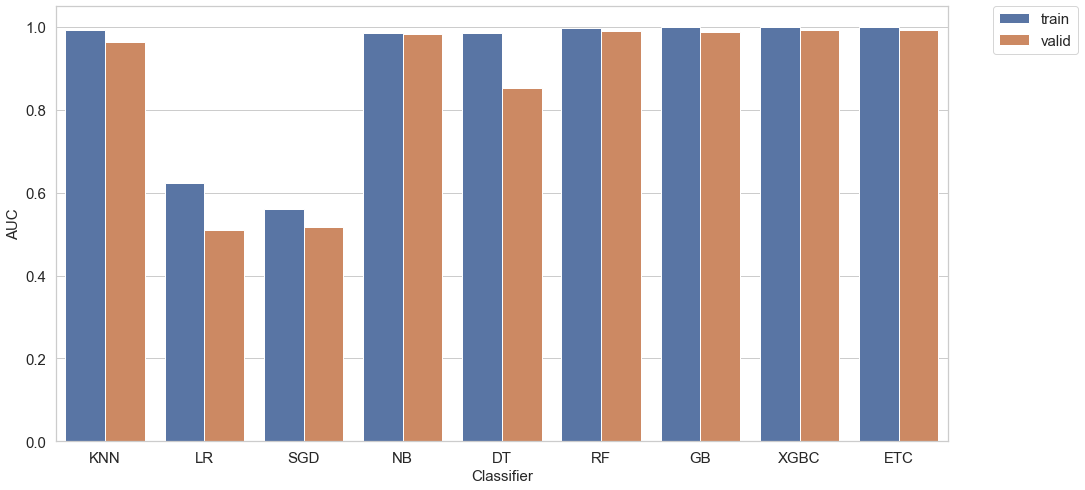

In [41]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
ax = sns.barplot(x = 'classifier', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classifier', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

#Separate legend from graph
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

<b>My current best model is the ExtraTrees Classifier, with a 99.6% validation AUC.</b>

In [42]:
# this is a quick way to tune one parameter of your model while holding everything else constant.
import time

my_params =  np.arange(0.05, 1.01, 0.05) # fill this in your list of parameters

# initialize arrays for storing the results
train_metrics = np.zeros(len(my_params))
valid_metrics = np.zeros(len(my_params))

# train a model for each param in a list
t1 = time.time()
for jj in range(len(my_params)):
    my_param = my_params[jj]
    
    # fit model
    model = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=my_param, min_samples_leaf=3, min_samples_split=20, n_estimators=100)
    model.fit(X_train_tf, y_train)
    # get predictions
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    metric_train = roc_auc_score(y_train, y_train_preds) # fill this in
    metric_valid = roc_auc_score(y_valid, y_valid_preds) # fill this in

    # save aucs
    train_metrics[jj] = metric_train
    valid_metrics[jj] = metric_valid
    
    # print the time
    t2 = time.time()
    print(my_param, t2-t1)
    t1 = time.time()

0.05 1.3758158683776855
0.1 1.3270065784454346
0.15000000000000002 1.2064049243927002
0.2 2.591609001159668
0.25 1.866804838180542
0.3 2.9276065826416016
0.35000000000000003 3.8636081218719482
0.4 3.7160093784332275
0.45 2.908407211303711
0.5 5.2098143100738525
0.55 3.1654090881347656
0.6000000000000001 2.4152064323425293
0.6500000000000001 2.4042060375213623
0.7000000000000001 3.0882062911987305
0.7500000000000001 8.00801682472229
0.8 5.451211929321289
0.8500000000000001 3.122807264328003
0.9000000000000001 5.9424121379852295
0.9500000000000001 3.779008626937866
1.0 3.4668095111846924


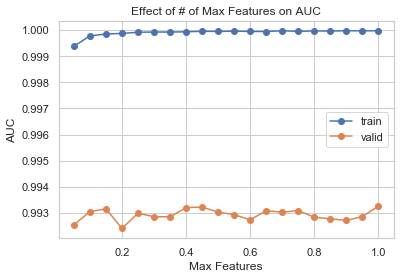

In [43]:

import matplotlib.pyplot as plt
plt.plot(my_params, train_metrics,'o-',label = 'train')
plt.plot(my_params, valid_metrics,'o-',label = 'valid')

plt.xlabel('Max Features') # fill this in
plt.ylabel('AUC')# fill this in
plt.title('Effect of # of Max Features on AUC') # fill this in
plt.legend()
plt.show()

## Learning Curves

We plot learning curves for our best performing model.

In [44]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    plt.figure(figsize=(16, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

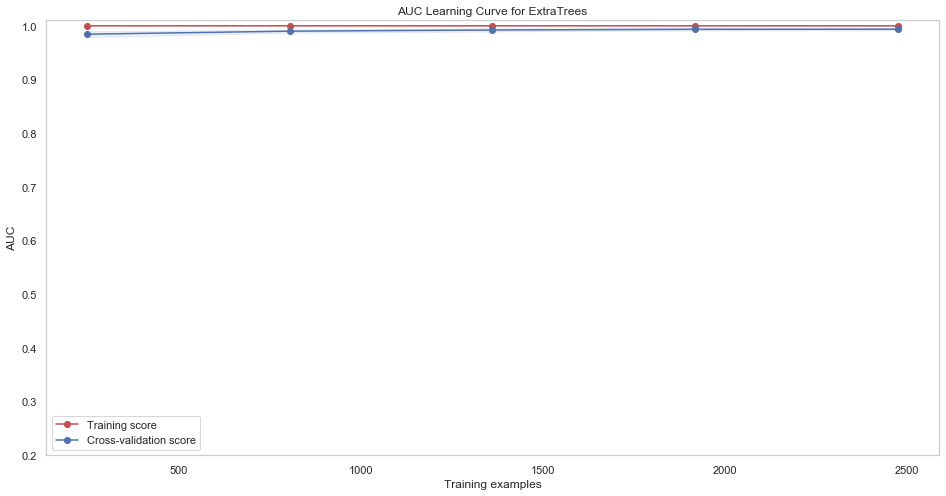

In [45]:
# score curves, each time with 20% data randomly selected as a validation set.


title = 'AUC Learning Curve for ExtraTrees'                                      # fill this in
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=1.0, min_samples_leaf=3, min_samples_split=20, n_estimators=100)                                      # fill this in
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)


plt.show()

My model has a low variance and a low bias. Not much can be done to improve the model, but I'll try running hyperparameter search using genetic programming.

Genetic programing or genetic algorithm (GA) is based on Charles Darwin's theory of survival of the fittest. GA applies small, slow, and random changes to the current hyperparameters. It works by assigning a fitness value to a solution, the higher the fitness value the higher the quality of the solution. It then selects the individuals with the highest fitness values and puts them into a "mating pool" where two individuals will generate two offspring (with some changes applied to the offspring), which is expected to have higher quality than their parents. This happens over and over until we get to the desired optimal value.

TPOT is an open source library under active development, first developed by researchers at the University of Pennselvania. It takes multiple copies of the entire training dataset, and performs its own variation of one-hot encoding (if needed), then optimizes the hyperparameteres using genetic algorithm.

## Feature Importance

In [46]:
feature_importances = pd.DataFrame(etc.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [47]:
feature_importances.head()

,importance
X162,0.020967
X161,0.017403
X158,0.016258
X95,0.015992
X136,0.013645


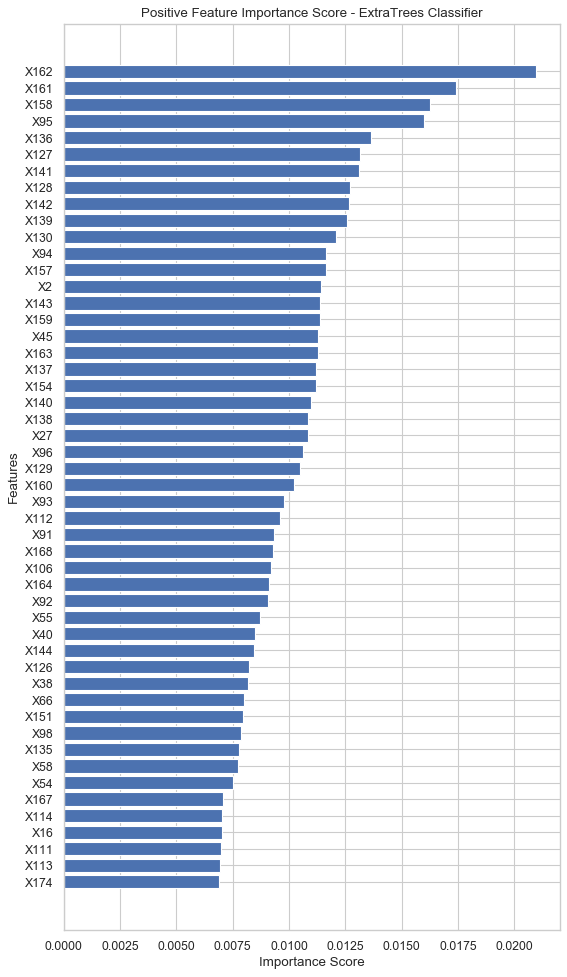

In [48]:
pos_features = feature_importances.loc[feature_importances.importance > 0]
num = np.min([50, len(pos_features)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = pos_features.iloc[:num].values.ravel()[::-1]
feature_labels = list(pos_features.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - ExtraTrees Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()


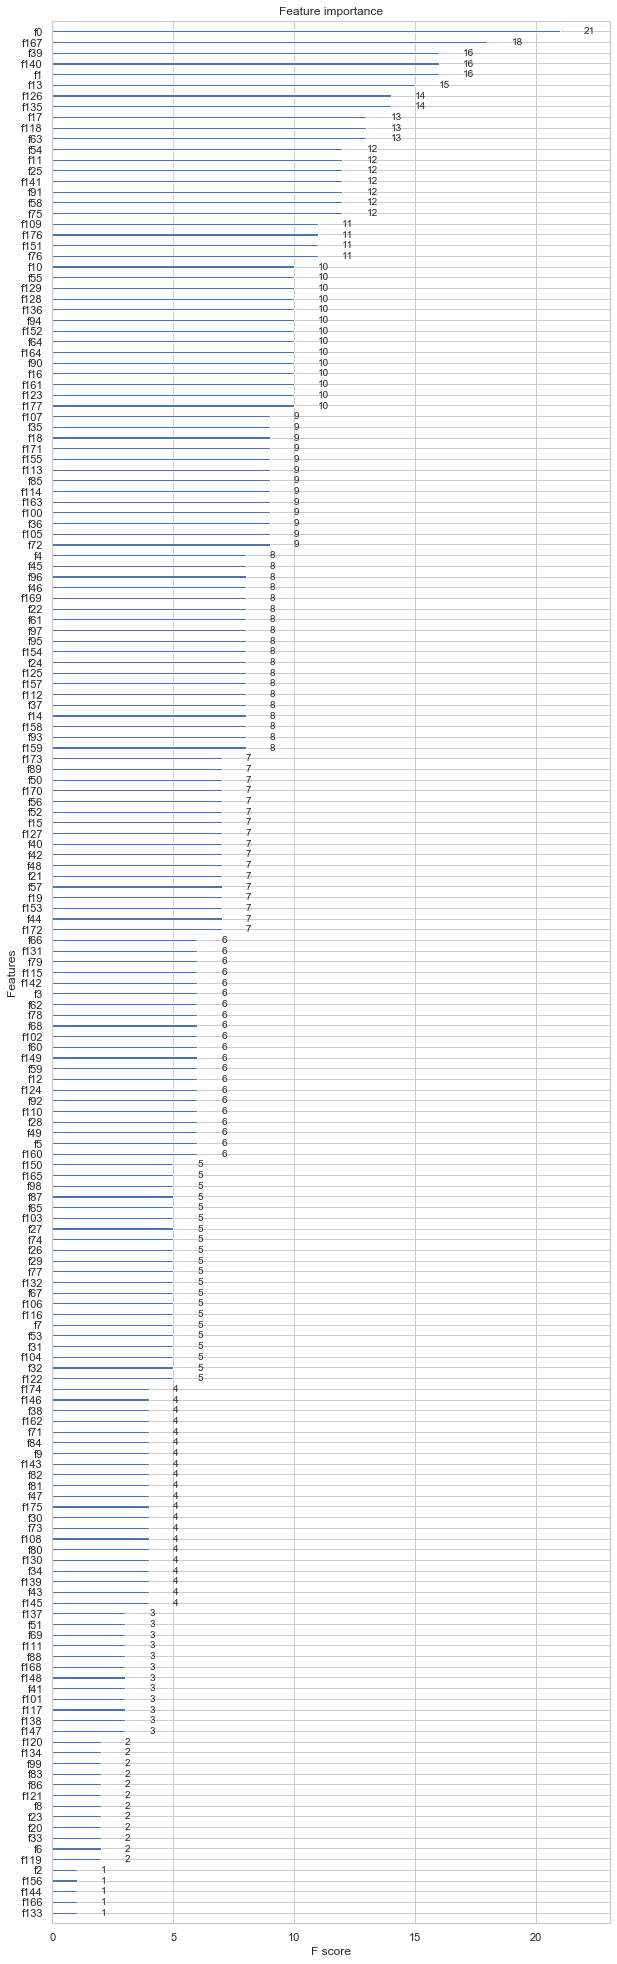

In [49]:
ax = xgb.plot_importance(xgbc)
fig = ax.figure
fig.set_size_inches(10, 35)
plt.savefig('xgbcf.png')

In [54]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [50]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X = df_train.drop(columns=['OUTPUT_LABEL'])
model = xgbc

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


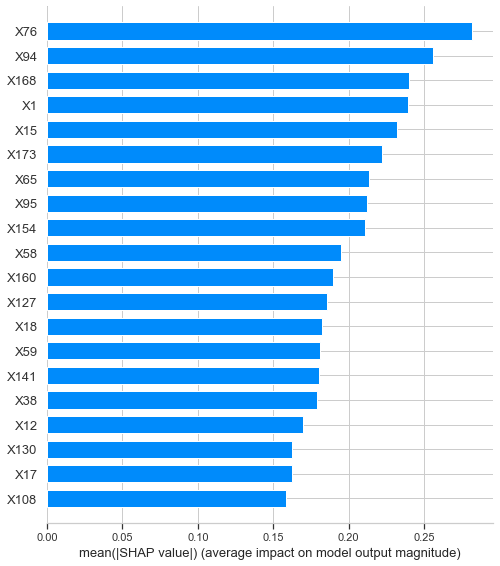

<Figure size 432x288 with 0 Axes>

In [51]:
shap.summary_plot(shap_values, X, plot_type="bar")
plt.savefig('shap.png')


In [52]:
feature_importances = pd.DataFrame(xgbc.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

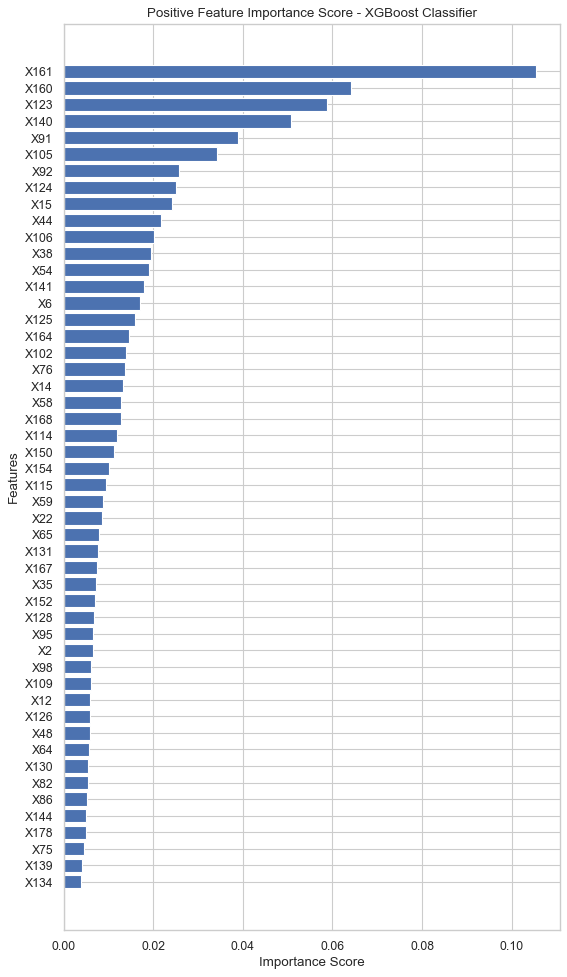

In [53]:
pos_features = feature_importances.loc[feature_importances.importance > 0]

num = np.min([50, len(pos_features)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = pos_features.iloc[:num].values.ravel()[::-1]
feature_labels = list(pos_features.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - XGBoost Classifier')
plt.yticks(ylocs, feature_labels)
plt.savefig('xgbc.png')
plt.show()


<b>Ultimately, all of my features should be equally important, since they are all EEG measures. Theoretically, there isn't any single one millisecond that is more important or predictive than any other millisecond in terms of determining whether a patient is having an epileptic seizure or not.</b>

# Hyperparameter tuning

Using RandomizedSearchCV, I optimized a few of your baseline models. Note that GradientBoosting Classifier may take a while so I might need to adjust the number of iterations or specific parameters.

In [54]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:50650 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.22 GB


In [60]:
pip install tpot

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install dask_ml

Note: you may need to restart the kernel to use updated packages.


In [55]:
from tpot import TPOTClassifier
import numpy as np
tpot_config = {
   ''' 'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'nthread': [1]
    },'''

    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    }

}
pipeline_optimizer = TPOTClassifier(verbosity=2, periodic_checkpoint_folder='tpot', generations=100, population_size=100, scoring='roc_auc', use_dask=True, config_dict=tpot_config)
pipeline_optimizer.fit(X_train_tf, y_train)
print(pipeline_optimizer.score(X_valid, y_valid))
pipeline_optimizer.export('tpot_exported_pipeline.py')

        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'nthread': [1]
    },sklearn.ensemble.ExtraTreesClassifier is not available and will not be used by TPOT.


RuntimeError: There was an error in the TPOT optimization process. This could be because the data was not formatted properly, or because data for a regression problem was provided to the TPOTClassifier object. Please make sure you passed the data to TPOT correctly.

<b>I Made a plot comparing the performance of the optimized models to the baseline models.</b>

In [59]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [60]:
best_model = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        make_union(
            make_union(
                FunctionTransformer(copy),
                make_union(
                    FunctionTransformer(copy),
                    make_union(
                        StackingEstimator(estimator=make_pipeline(
                            make_union(
                                FunctionTransformer(copy),
                                FunctionTransformer(copy)
                            ),
                            ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.1,
                                                 min_samples_leaf=10, min_samples_split=10, n_estimators=100)
                        )),
                        FunctionTransformer(copy)
                    )
                )
            ),
            FunctionTransformer(copy)
        )
    ),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.05,
                         min_samples_leaf=2, min_samples_split=4, n_estimators=100)
)

best_model.fit(X_train_tf, y_train)

y_train_preds = best_model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:, 1]

print('ExtraTrees Classifier')
print('Training:')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(
    y_train, y_train_preds, thresh)
print('Validation:')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh)

ExtraTrees Classifier
Training:
AUC:1.000
accuracy:1.000
recall:0.999
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.994
accuracy:0.945
recall:0.961
precision:0.797
specificity:0.941
prevalence:0.194
 


<b>I passed XGBoost and ExtraTrees classifiers to TPOT and the output is the best performing model between the two classifiers. In the end, the ExtraTrees classifier was superior to XGBoost in AUC.</b>

# Pick your best model

I picked the model simply because it has the highest validation AUC, since that is the metric I picked to evaluate my models.

In [61]:
pickle.dump(best_model, open('best_classifier.pkl', 'wb'),protocol = 4)

# Model Evaluation

 I evaluated the performance of the best model on the training, validation and test sets and made an ROC curve.

In [62]:
# load the model, columns, and scaler
best_model = pickle.load(open('best_classifier.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
scaler = pickle.load(open('scaler.sav', 'rb'))

# load the data
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')
df_test= pd.read_csv('df_test.csv')

# create X and y matrices
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values
y_test = df_test['OUTPUT_LABEL'].values

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

### Calculate prediction probabilities

In [63]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

### Performance evaluation

In [64]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:1.000
accuracy:1.000
recall:0.999
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.994
accuracy:0.945
recall:0.961
precision:0.797
specificity:0.941
prevalence:0.194
 
Test:
AUC:0.995
accuracy:0.955
recall:0.967
precision:0.828
specificity:0.953
prevalence:0.191
 


### ROC Curve

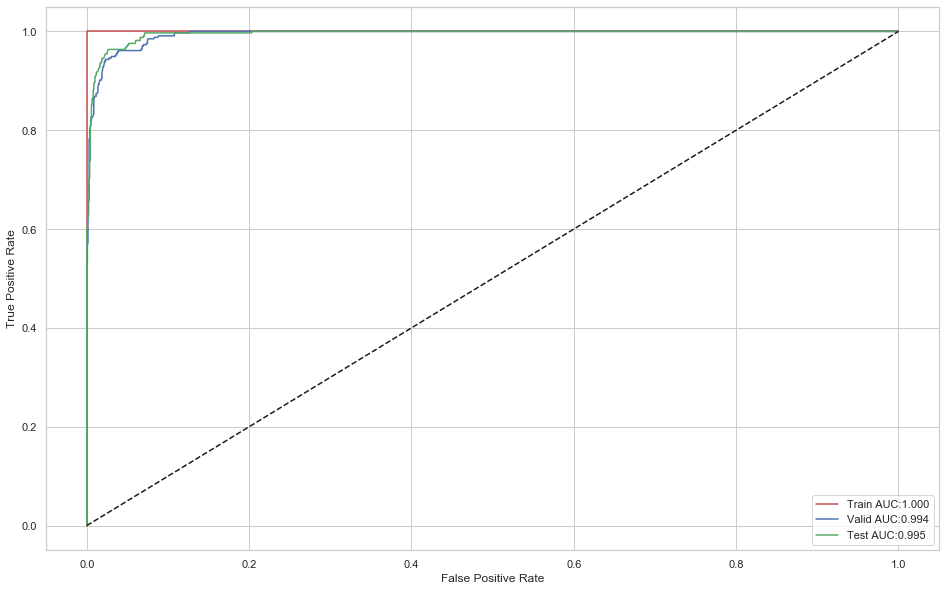

In [66]:
from sklearn.metrics import roc_curve 
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusion

The best performing model has a lift performance of 4.3, meaning it is 4.3 times better than just randomly guessing. It is also 97.4% correct in predicting the positive classes in the test set. If this model was put into production to predict whether a patient is having a seizure, you could expect that performance in correctly predicting those who are having a seizure.